In [12]:
arch_map = {'': 'Baseline',
            'AC': 'Adaptive Clipper',
            'MF': 'Median Filter',
            'ranger': 'Ranger',
            'SR': 'Swap ReLU6',
            'TMR': 'TMR'
 }

In [13]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

os.chdir("/home/bepi/Desktop/Ph.D_/projects/APP_FI/data/")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/bepi/Desktop/Ph.D_/projects/APP_FI/data/") if file_path.startswith("FSIM_N_HPC_mnasnet") and not file_path.endswith('gz')]
# print(log_folders)

general_report = pd.DataFrame([])
new_report = pd.DataFrame([])
for layer_conf in log_folders:
    model = layer_conf.split('_')[3]
    architecture = ''
    if len(layer_conf.split('_')) == 5:
        architecture = layer_conf.split('_')[4]

    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store" and not files.endswith('.log')]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "fsim_full_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"

            report.drop(columns=['Unnamed: 0'], inplace=True)
            
            report['MRAD']=abs(100*(report['fault_ACC@1']-report['gold_ACC@1'])/report['gold_ACC@1'])
            report['MRADk']=abs(100*(report['fault_ACC@k']-report['gold_ACC@k'])/report['gold_ACC@k'])
            report['AbsAD']=abs((report['fault_ACC@1']-report['gold_ACC@1']))
            report['AbsADk']=abs((report['fault_ACC@k']-report['gold_ACC@k']))

            report['MRF1D']=abs(100*(report['fault_f1@1']-report['goldenf1_1'])/report['goldenf1_1'])
            report['MRF1Dk']=abs(100*(report['fault_f1@k']-report['goldenf1_k'])/report['goldenf1_k'])
            report['AbsF1D']=abs((report['fault_f1@1']-report['goldenf1_1']))
            report['AbsF1Dk']=abs((report['fault_f1@k']-report['goldenf1_k']))

            report['MRRD']=abs(100*(report['fault_rec@1']-report['goldenrec_1'])/report['goldenrec_1'])
            report['MRRDk']=abs(100*(report['fault_rec@k']-report['goldenrec_k'])/report['goldenrec_k'])
            report['AbsrD']=abs((report['fault_rec@1']-report['goldenrec_1']))
            report['AbsRDk']=abs((report['fault_rec@k']-report['goldenrec_k']))

            report['MRPD']=abs(100*(report['fault_prec@1']-report['goldenprec_1'])/report['goldenprec_1'])
            report['MRPDk']=abs(100*(report['fault_prec@k']-report['goldenprec_k'])/report['goldenprec_k'])
            report['AbsPD']=abs((report['fault_prec@1']-report['goldenprec_1']))
            report['AbsPDk']=abs((report['fault_prec@k']-report['goldenprec_k']))
            report['model'] = 'LeNet5'
            report['Architecture'] = arch_map[architecture]
            report['block_fault_rate'] = report['block_fault_rate']*100
            report['neuron_fault_rate'] = report['neuron_fault_rate']*100
            general_report = pd.concat([general_report, report], axis=0, ignore_index=True)

            # new_path = os.path.join(file_path, "Misclassified_images_report.csv")
            # additional_report = pd.read_csv(new_path)
            # additional_report['model'] = 'LeNet5'
            # additional_report['Architecture'] = arch_map[architecture]
            # new_report = pd.concat([new_report, additional_report], axis=0, ignore_index=True)
            # new_report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"



In [14]:
general_report[general_report['Architecture'] == 'Baseline']['fault_ACC@1'].min()

4.0

## Preliminary check of NaN/inf values

In [15]:
# TODO: check nan/inf values
general_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26000 entries, 0 to 25999
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   layer_start        26000 non-null  int64  
 1   layer_stop         26000 non-null  int64  
 2   size_tail_y        26000 non-null  int64  
 3   size_tail_x        26000 non-null  int64  
 4   block_fault_rate   26000 non-null  float64
 5   neuron_fault_rate  26000 non-null  float64
 6   bit_faulty_pos     26000 non-null  int64  
 7   gold_ACC@1         26000 non-null  float64
 8   gold_ACC@k         26000 non-null  float64
 9   img_Top1_Crit      26000 non-null  int64  
 10  img_Top1_SDC       26000 non-null  int64  
 11  img_Top1_Masked    26000 non-null  int64  
 12  img_Topk_Crit      26000 non-null  int64  
 13  img_Topk_SDC       26000 non-null  int64  
 14  img_Topk_Masked    26000 non-null  int64  
 15  fault_ACC@1        26000 non-null  float64
 16  fault_ACC@k        260

## Accuracy of the corrupted NN
#### (The accuracy is evaluated considering only the top1 prediction)

In [16]:
general_report['BER'] = general_report['neuron_fault_rate'] * general_report['block_fault_rate']

general_report[general_report['BER']==general_report['BER'].unique()[0]].groupby('Architecture')['fault_ACC@1'].mean()

Architecture
Adaptive Clipper    49.446154
Baseline            45.030769
Ranger              48.523077
TMR                 69.415385
Name: fault_ACC@1, dtype: float64

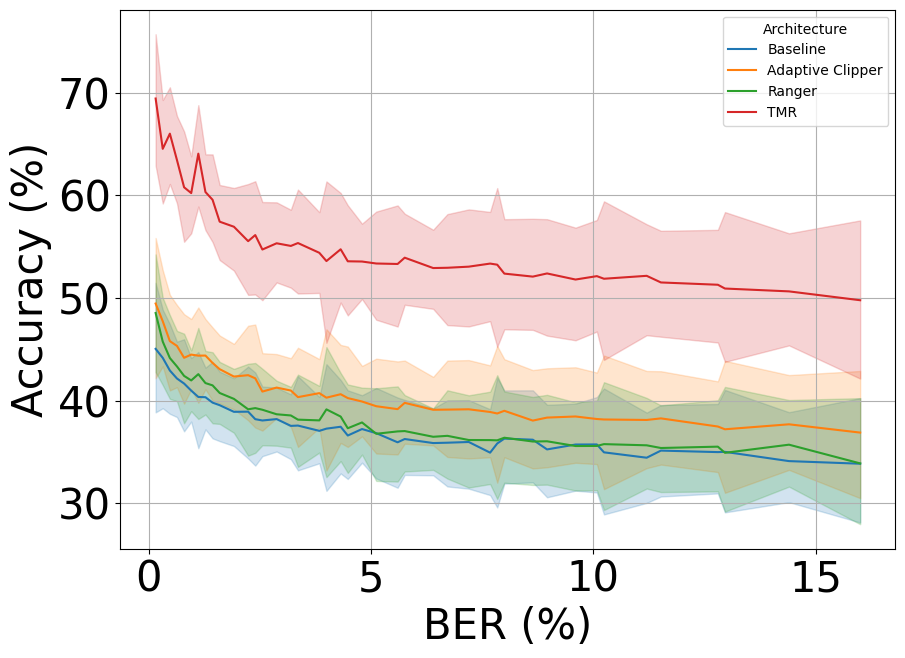

In [18]:
general_report['BER'] = general_report['neuron_fault_rate'] * general_report['block_fault_rate']
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1,figsize=(10,7))
legend_order = ['Baseline', 'Adaptive Clipper', 'Ranger', 'TMR']
sns.lineplot(data=general_report, x='BER', y='fault_ACC@1', hue='Architecture', ax = ax, hue_order=legend_order)

ax.grid()
ax.set_ylabel('Accuracy (%)', fontsize=30)
ax.set_xlabel('BER (%)', fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
# ax.set_xticklabels(labels=general_report['BER'].unique())
# ax.tick_params(axis='x', labelsize=30)
# x_min, x_max = general_report['BER'].min(), general_report['BER'].max()

# ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
# x_ticks = np.linspace(x_min, x_max, 10)
# ax.set_xticklabels([f'{tick:.2f}' for tick in general_report['BER'].unique()], rotation=0)
# ax.set_xlim(left=-2.5)

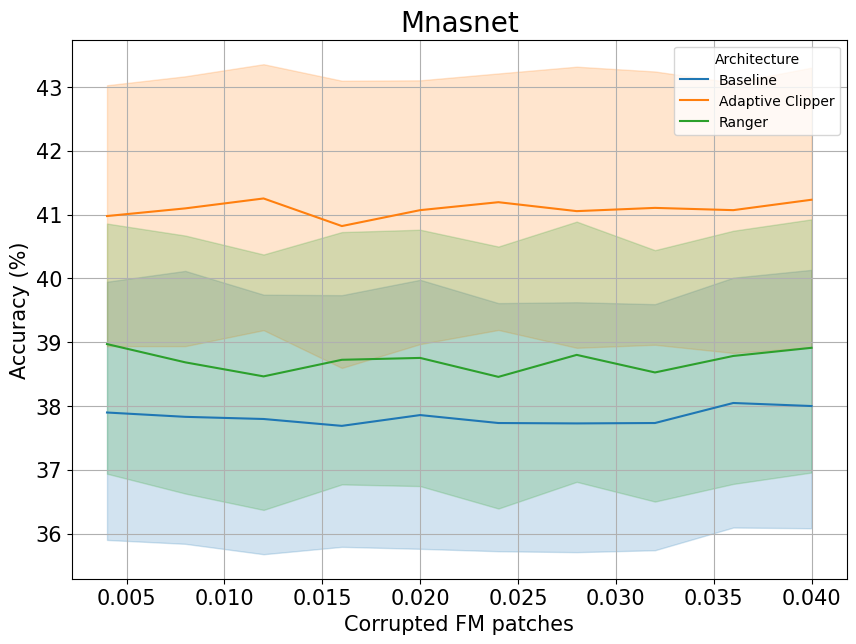

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=general_report, x='block_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
# sns.scatterplot(data=general_report, x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('Accuracy (%)', fontsize=15)
ax.set_xlabel('Corrupted FM patches', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

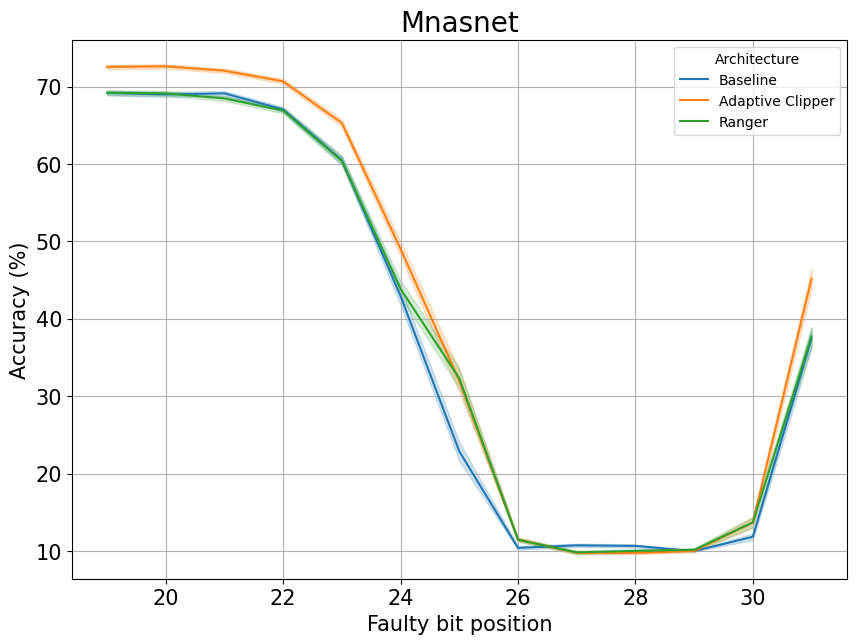

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=general_report, x='bit_faulty_pos', y='fault_ACC@1', hue='Architecture', ax = ax)
# sns.scatterplot(data=general_report, x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('Accuracy (%)', fontsize=15)
ax.set_xlabel('Faulty bit position', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

### Let's isolate bit 30

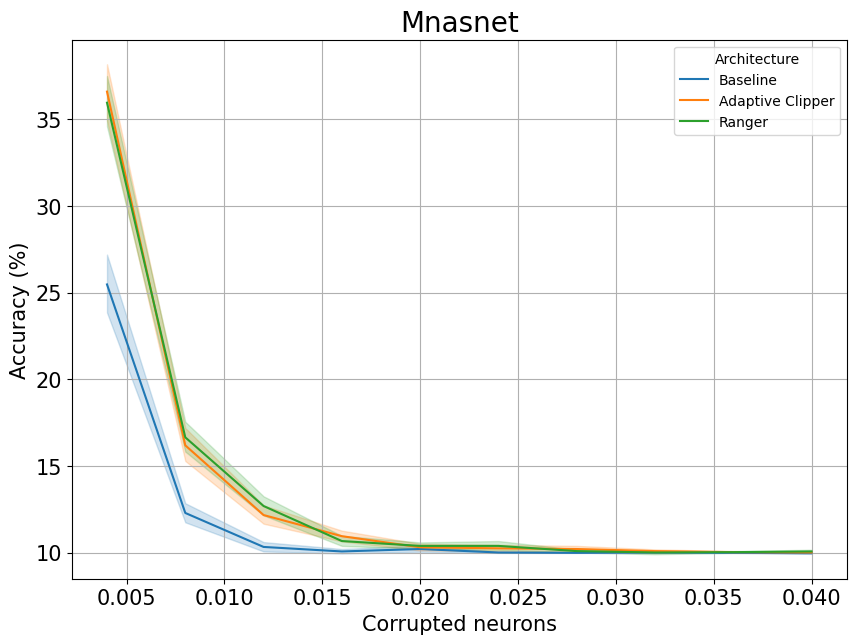

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=general_report[general_report['bit_faulty_pos']==30], x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
# sns.boxplot(data=general_report[general_report['bit_faulty_pos']==30], x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('Accuracy (%)', fontsize=15)
ax.set_xlabel('Corrupted neurons', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

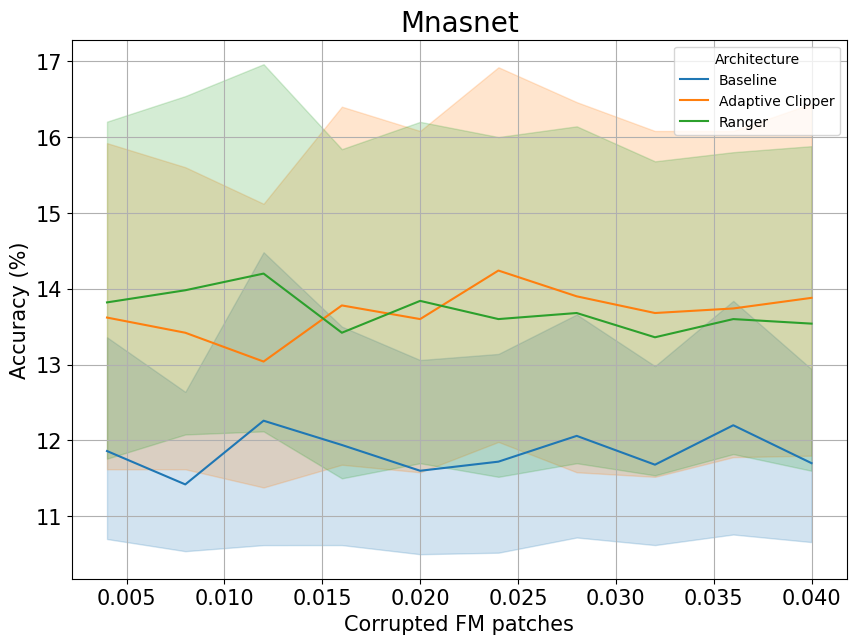

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=general_report[general_report['bit_faulty_pos']==30], x='block_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
# sns.scatterplot(data=general_report, x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('Accuracy (%)', fontsize=15)
ax.set_xlabel('Corrupted FM patches', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

## NaN values in NN output

In [33]:
new_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369120 entries, 0 to 369119
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         369120 non-null  int64  
 1   FaultID            369120 non-null  object 
 2   imID               369120 non-null  int64  
 3   layer_start        369120 non-null  int64  
 4   layer_stop         369120 non-null  int64  
 5   size_tail_y        369120 non-null  int64  
 6   size_tail_x        369120 non-null  int64  
 7   block_fault_rate   369120 non-null  float64
 8   neuron_fault_rate  369120 non-null  float64
 9   bit_faulty_pos     369120 non-null  int64  
 10  G_Target           369120 non-null  int64  
 11  F_clas0            369120 non-null  int64  
 12  F_clas1            369120 non-null  int64  
 13  F_clas2            369120 non-null  int64  
 14  F_clas3            369120 non-null  int64  
 15  F_clas4            369120 non-null  int64  
 16  F_

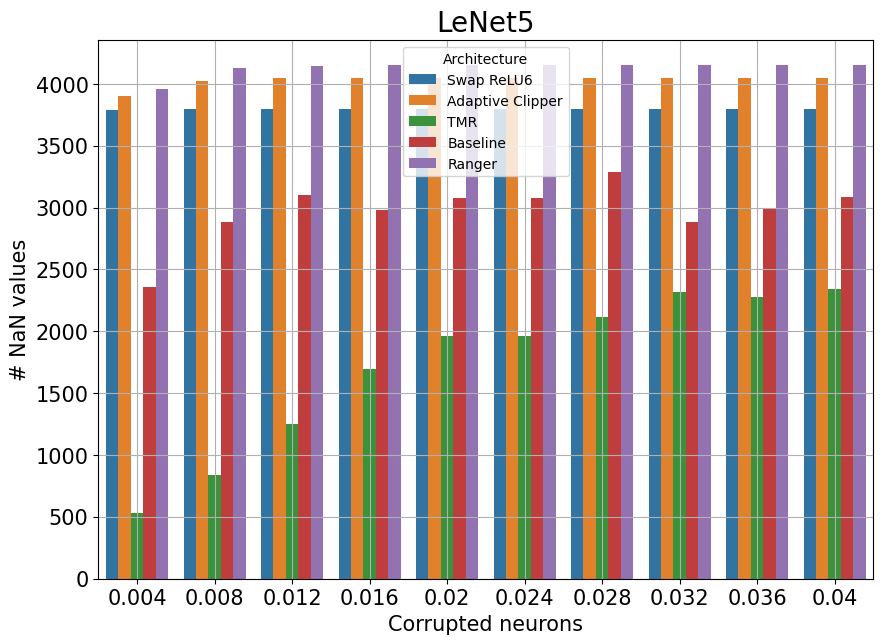

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.countplot(data = new_report.query("F_pred0.isnull()"), x='neuron_fault_rate', hue='Architecture',  ax = ax)

ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('# NaN values', fontsize=15)
ax.set_xlabel('Corrupted neurons', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# fig.legend()

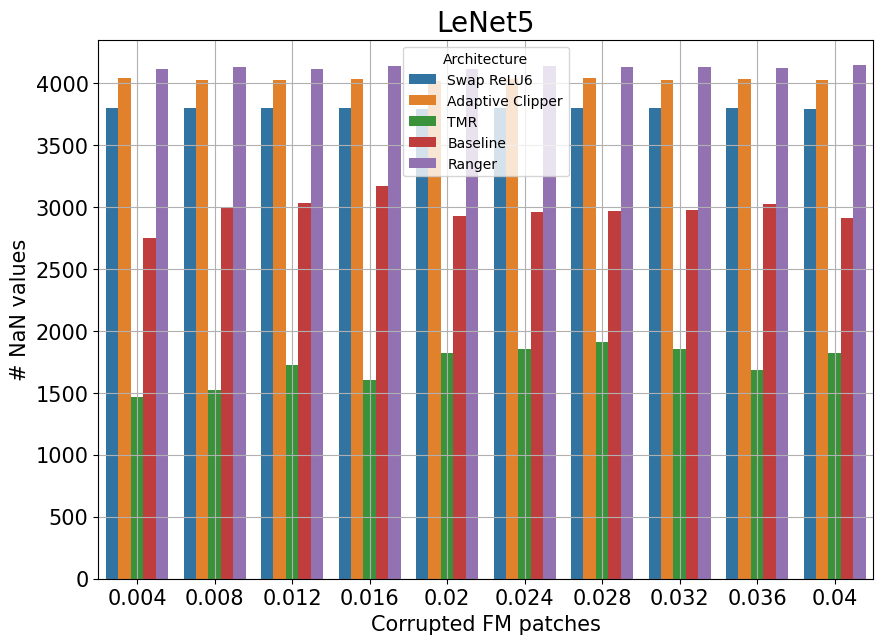

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.countplot(data = new_report.query("F_pred0.isnull()"), x='block_fault_rate', hue='Architecture',  ax = ax)

ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('# NaN values', fontsize=15)
ax.set_xlabel('Corrupted FM patches', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# fig.legend()

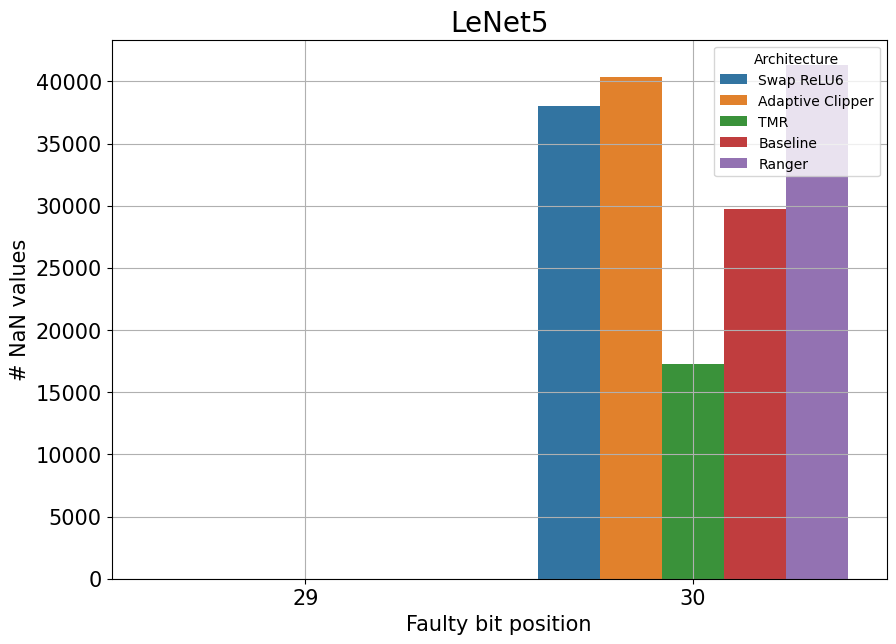

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.countplot(data = new_report.query("F_pred0.isnull()"), x='bit_faulty_pos', hue='Architecture',  ax = ax)

ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('# NaN values', fontsize=15)
ax.set_xlabel('Faulty bit position', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
# fig.legend()

## Top1 - Top2 
#### It is worth to explore also this metric becuase, when models are deployed into a CPS, if the difference between the top1 and top2 predictions are too close, so if the model is not confident enough on the top1 prediction, it is discarded.
(A reference is needed)

In [38]:
new_report['top_diff'] = abs(new_report['F_pred0'] - new_report['F_pred1'])/abs(new_report['F_pred0']+new_report['F_pred1']+new_report['F_pred2']+new_report['F_pred3']+new_report['F_pred4'])

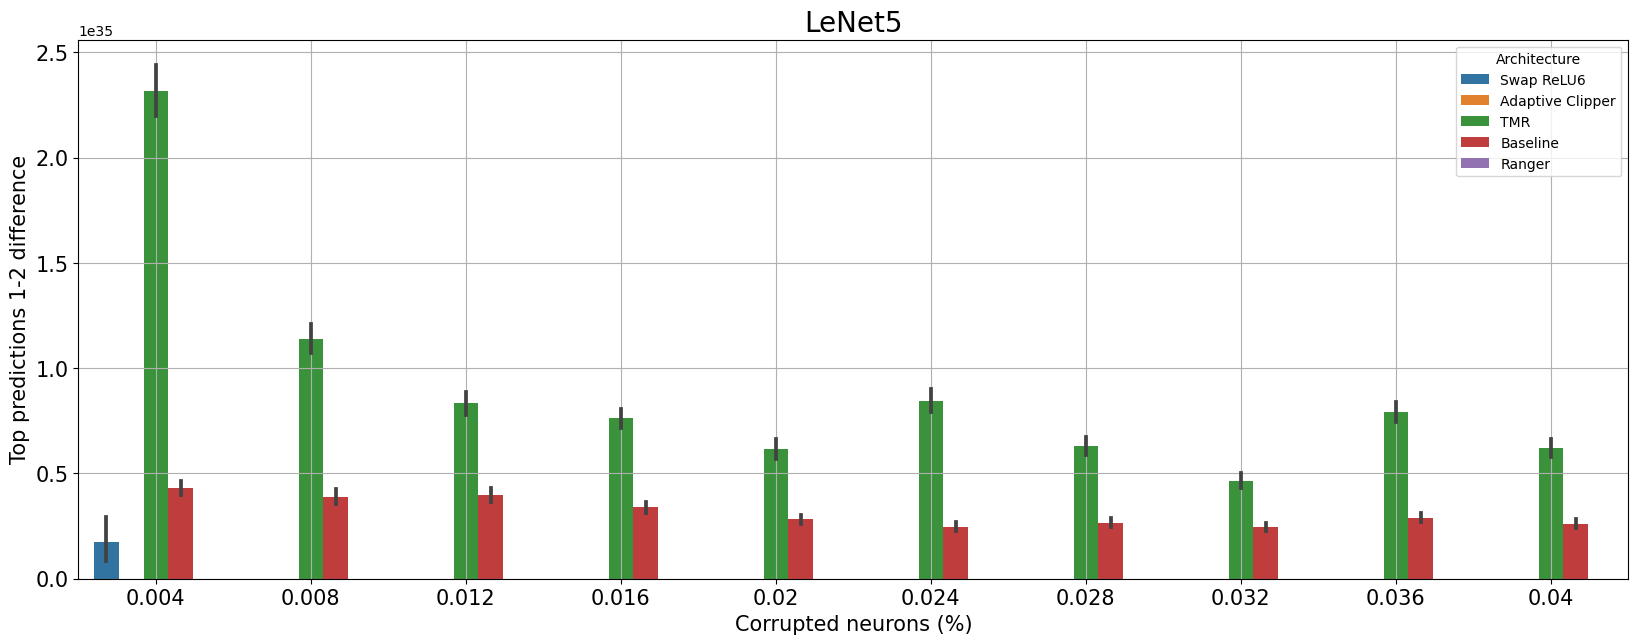

In [39]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
sns.barplot(data=new_report, x='neuron_fault_rate', y='top_diff', hue='Architecture', ax = ax)
# sns.boxplot(data=general_report[general_report['bit_faulty_pos']==30], x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('Top predictions 1-2 difference', fontsize=15)
ax.set_xlabel('Corrupted neurons (%)', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

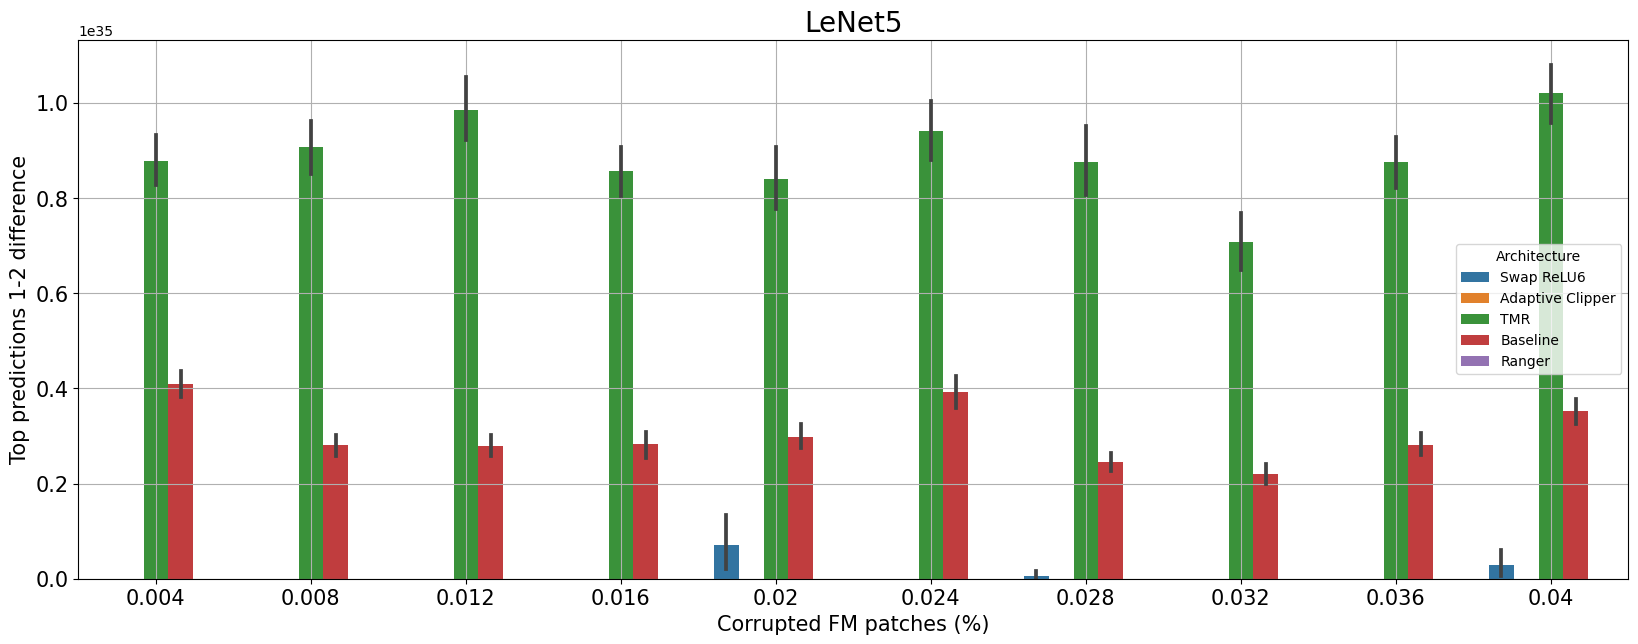

In [40]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
sns.barplot(data=new_report, x='block_fault_rate', y='top_diff', hue='Architecture', ax = ax)
# sns.boxplot(data=general_report[general_report['bit_faulty_pos']==30], x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('Top predictions 1-2 difference', fontsize=15)
ax.set_xlabel('Corrupted FM patches (%)', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

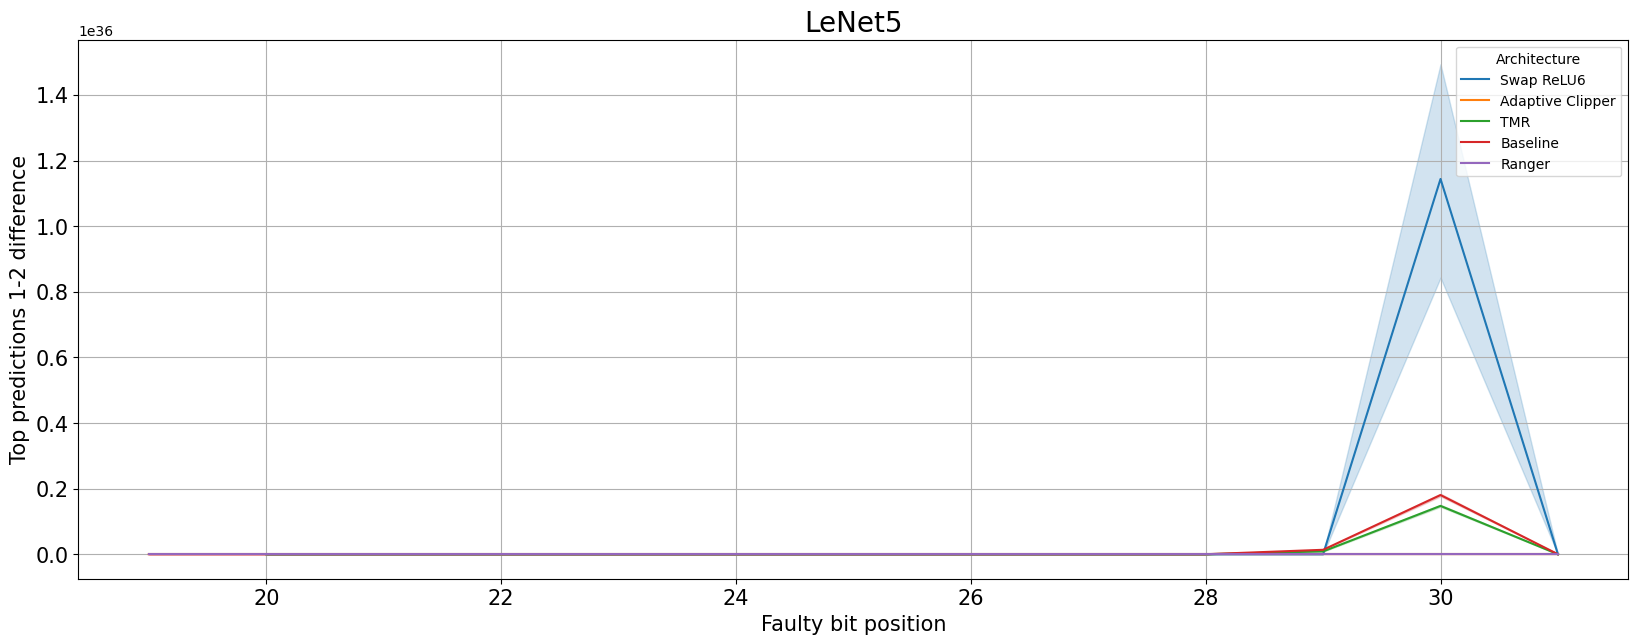

In [42]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
# sns.lineplot(data=new_report, x='bit_faulty_pos', y='top_diff', hue='Architecture', ax = ax)
sns.lineplot(data=new_report, x='bit_faulty_pos', y='top_diff', hue='Architecture', ax = ax)
# sns.boxplot(data=general_report[general_report['bit_faulty_pos']==30], x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mnasnet', fontsize=20)
ax.grid()
ax.set_ylabel('Top predictions 1-2 difference', fontsize=15)
ax.set_xlabel('Faulty bit position', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

#### Filter by correct predictions
Correctness is evaluated w.r.t. the ground truth

In [43]:
new_report.columns

Index(['Unnamed: 0', 'FaultID', 'imID', 'layer_start', 'layer_stop',
       'size_tail_y', 'size_tail_x', 'block_fault_rate', 'neuron_fault_rate',
       'bit_faulty_pos', 'G_Target', 'F_clas0', 'F_clas1', 'F_clas2',
       'F_clas3', 'F_clas4', 'F_pred0', 'F_pred1', 'F_pred2', 'F_pred3',
       'F_pred4', 'G_clas0', 'G_clas1', 'G_clas2', 'G_clas3', 'G_clas4',
       'G_pred0', 'G_pred1', 'G_pred2', 'G_pred3', 'G_pred4', 'model',
       'Architecture', 'conf_detail', 'top_diff'],
      dtype='object')

In [44]:
correct_predictions = new_report[new_report['G_Target']==new_report['F_clas0']]
len(correct_predictions)

0

Correct predictions is empty which means that, when LeNet5 predictions are affected by the induced error, all faults are "critical" (i.e., the prediction has changed)

In [45]:
arch_map = {'': 'Baseline',
            'AC': 'Adaptive Clipper',
            'MF': 'Median Filter',
            'ranger': 'Ranger',
            'SR': 'Swap ReLU6',
            'TMR': 'TMR'}

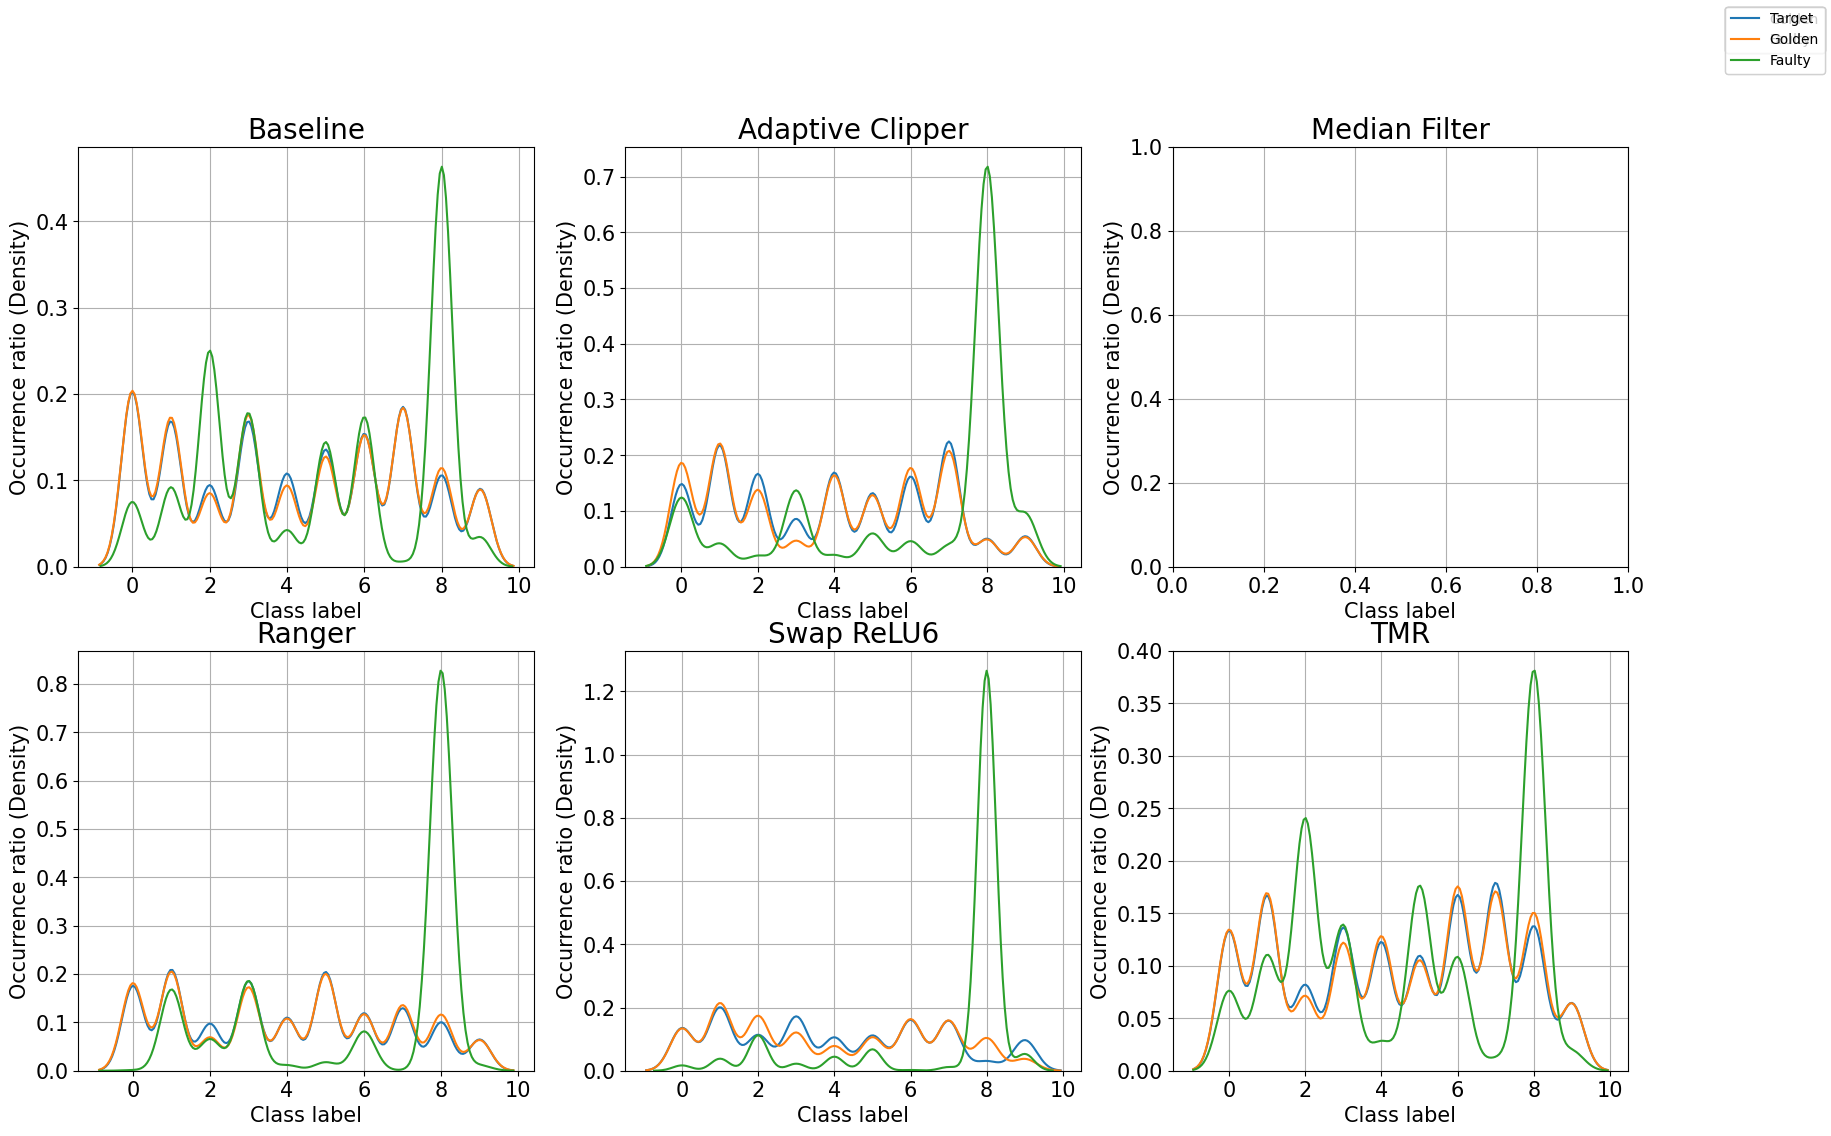

In [46]:
fig, ax = plt.subplots(2,3,figsize=(20,12))
sns.kdeplot(data=new_report[new_report['Architecture']=='Baseline'], x='G_Target', ax = ax[0][0], common_norm=True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Baseline'], x='G_clas0', ax = ax[0][0], common_norm=True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Baseline'], x='F_clas0', ax = ax[0][0], common_norm=True)
ax[0][0].set_title('Baseline', fontsize=20)
ax[0][0].grid()
ax[0][0].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[0][0].set_xlabel('Class label', fontsize=15)
ax[0][0].tick_params(axis='x', labelsize=15)
ax[0][0].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Target','Golden', 'Faulty'])

sns.kdeplot(data=new_report[new_report['Architecture']=='Adaptive Clipper'], x='G_Target', ax = ax[0][1], common_norm= True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Adaptive Clipper'], x='G_clas0', ax = ax[0][1], common_norm= True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Adaptive Clipper'], x='F_clas0', ax = ax[0][1], common_norm= True)
ax[0][1].set_title('Adaptive Clipper', fontsize=20)
ax[0][1].grid()
ax[0][1].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[0][1].set_xlabel('Class label', fontsize=15)
ax[0][1].tick_params(axis='x', labelsize=15)
ax[0][1].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Golden', 'Faulty'])

sns.kdeplot(data=new_report[new_report['Architecture']=='Median Filter'], x='G_Target', ax = ax[0][2], common_norm= True, common_grid=True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Median Filter'], x='G_clas0', ax = ax[0][2], common_norm= True, common_grid=True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Median Filter'], x='F_clas0', ax = ax[0][2], common_norm= True, common_grid=True)
ax[0][2].set_title('Median Filter', fontsize=20)
ax[0][2].grid()
ax[0][2].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[0][2].set_xlabel('Class label', fontsize=15)
ax[0][2].tick_params(axis='x', labelsize=15)
ax[0][2].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Golden', 'Faulty'])

sns.kdeplot(data=new_report[new_report['Architecture']=='Ranger'], x='G_Target', ax = ax[1][0], common_norm= True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Ranger'], x='G_clas0', ax = ax[1][0], common_norm= True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Ranger'], x='F_clas0', ax = ax[1][0], common_norm= True)
ax[1][0].set_title('Ranger', fontsize=20)
ax[1][0].grid()
ax[1][0].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[1][0].set_xlabel('Class label', fontsize=15)
ax[1][0].tick_params(axis='x', labelsize=15)
ax[1][0].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Golden', 'Faulty'])

sns.kdeplot(data=new_report[new_report['Architecture']=='Swap ReLU6'], x='G_Target', ax = ax[1][1], common_norm=True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Swap ReLU6'], x='G_clas0', ax = ax[1][1], common_norm=True)
sns.kdeplot(data=new_report[new_report['Architecture']=='Swap ReLU6'], x='F_clas0', ax = ax[1][1], common_norm=True)
ax[1][1].set_title('Swap ReLU6', fontsize=20)
ax[1][1].grid()
ax[1][1].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[1][1].set_xlabel('Class label', fontsize=15)
ax[1][1].tick_params(axis='x', labelsize=15)
ax[1][1].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Golden', 'Faulty'])

sns.kdeplot(data=new_report[new_report['Architecture']=='TMR'], x='G_Target', ax = ax[1][2], common_norm=True)
sns.kdeplot(data=new_report[new_report['Architecture']=='TMR'], x='G_clas0', ax = ax[1][2], common_norm=True)
sns.kdeplot(data=new_report[new_report['Architecture']=='TMR'], x='F_clas0', ax = ax[1][2], common_norm=True)
ax[1][2].set_title('TMR', fontsize=20)
ax[1][2].grid()
ax[1][2].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[1][2].set_xlabel('Class label', fontsize=15)
ax[1][2].tick_params(axis='x', labelsize=15)
ax[1][2].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Target','Golden', 'Faulty'])

In [ ]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(6,2,figsize=(12,30))
cm = confusion_matrix(new_report[new_report['Architecture']=='Baseline']['F_clas0'], new_report[new_report['Architecture']=='Baseline']['G_Target'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[0][0])
ax[0][0].set_title('Corrupted Baseline', fontsize=20)
# ax[0][0].grid()
ax[0][0].set_ylabel('Predicted', fontsize=15)
ax[0][0].set_xlabel('', fontsize=15)
ax[0][0].tick_params(axis='x', labelsize=15)
ax[0][0].tick_params(axis='y', labelsize=15)

cm = confusion_matrix(new_report[new_report['Architecture']=='Baseline']['G_clas0'], new_report[new_report['Architecture']=='Baseline']['G_Target'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[0][1])
ax[0][1].set_title('Golden Baseline', fontsize=20)
# ax[0][1].grid()
ax[0][1].set_ylabel('', fontsize=15)
ax[0][1].set_xlabel('', fontsize=15)
ax[0][1].tick_params(axis='x', labelsize=15)
ax[0][1].tick_params(axis='y', labelsize=15)

cm = confusion_matrix(new_report[new_report['Architecture']=='Adaptive Clipper']['F_clas0'], new_report[new_report['Architecture']=='Adaptive Clipper']['G_Target'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[1][0])
ax[1][0].set_title('Corrupted Adaptive Clipper', fontsize=20)
# ax[1][0].grid()
ax[1][0].set_ylabel('Corrupted Adaptive Clipper', fontsize=15)
ax[1][0].set_xlabel('', fontsize=15)
ax[1][0].tick_params(axis='x', labelsize=15)
ax[1][0].tick_params(axis='y', labelsize=15)

cm = confusion_matrix(new_report[new_report['Architecture']=='Adaptive Clipper']['G_clas0'], new_report[new_report['Architecture']=='Adaptive Clipper']['G_Target'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[1][1])
ax[1][1].set_title('Golden Adaptive Clipper', fontsize=20)
# ax[1][1].grid()
ax[1][1].set_ylabel('', fontsize=15)
ax[1][1].set_xlabel('', fontsize=15)
ax[1][1].tick_params(axis='x', labelsize=15)
ax[1][1].tick_params(axis='y', labelsize=15)

# cm = confusion_matrix(new_report[new_report['Architecture']=='Median Filter']['F_clas0'], new_report[new_report['Architecture']=='Median Filter']['G_clas0'], normalize='true')
# sns.heatmap(cm, fmt="d", cbar=True, ax=ax[0][2])
ax[2][0].set_title('Median Filter', fontsize=20)
ax[2][0].grid()
# ax[2][0].set_ylabel('Predicted', fontsize=15)
# ax[2][0].set_xlabel('', fontsize=15)
# ax[2][0].tick_params(axis='x', labelsize=15)
# ax[2][0].tick_params(axis='y', labelsize=15)

# cm = confusion_matrix(new_report[new_report['Architecture']=='Median Filter']['G_clas0'], new_report[new_report['Architecture']=='Median Filter']['G_Target'], normalize='true')
# sns.heatmap(cm, fmt="d", cbar=True, ax=ax[0][2])
ax[2][1].set_title('Median Filter', fontsize=20)
ax[2][1].grid()
# ax[2][1].set_ylabel('Predicted', fontsize=15)
# ax[2][1].set_xlabel('', fontsize=15)
# ax[2][1].tick_params(axis='x', labelsize=15)
# ax[2][1].tick_params(axis='y', labelsize=15)

cm = confusion_matrix(new_report[new_report['Architecture']=='Ranger']['F_clas0'], new_report[new_report['Architecture']=='Ranger']['G_clas0'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[3][0])
ax[3][0].set_title('Corrupted Ranger', fontsize=20)
# ax[3][0].grid()
ax[3][0].set_ylabel('Predicted', fontsize=15)
ax[3][0].set_xlabel('', fontsize=15)
ax[3][0].tick_params(axis='x', labelsize=15)
ax[3][0].tick_params(axis='y', labelsize=15)

cm = confusion_matrix(new_report[new_report['Architecture']=='Ranger']['G_clas0'], new_report[new_report['Architecture']=='Ranger']['G_Target'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[3][1])
ax[3][1].set_title('Golden Ranger', fontsize=20)
# ax[3][1].grid()
ax[3][1].set_ylabel('', fontsize=15)
ax[3][1].set_xlabel('', fontsize=15)
ax[3][1].tick_params(axis='x', labelsize=15)
ax[3][1].tick_params(axis='y', labelsize=15)

cm = confusion_matrix(new_report[new_report['Architecture']=='Swap ReLU6']['F_clas0'], new_report[new_report['Architecture']=='Swap ReLU6']['G_Target'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[4][0])
ax[4][0].set_title('Corrupted Swap ReLU6', fontsize=20)
# ax[4][0].grid()
ax[4][0].set_ylabel('Predicted', fontsize=15)
ax[4][0].set_xlabel('', fontsize=15)
ax[4][0].tick_params(axis='x', labelsize=15)
ax[4][0].tick_params(axis='y', labelsize=15)

cm = confusion_matrix(new_report[new_report['Architecture']=='Swap ReLU6']['G_clas0'], new_report[new_report['Architecture']=='Swap ReLU6']['G_Target'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[4][1])
ax[4][1].set_title('Golden Swap ReLU6', fontsize=20)
# ax[4][1].grid()
ax[4][1].set_ylabel('', fontsize=15)
ax[4][1].set_xlabel('', fontsize=15)
ax[4][1].tick_params(axis='x', labelsize=15)
ax[4][1].tick_params(axis='y', labelsize=15)

cm = confusion_matrix(new_report[new_report['Architecture']=='TMR']['F_clas0'], new_report[new_report['Architecture']=='TMR']['G_Target'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[5][0])
ax[5][0].set_title('Corrupted TMR', fontsize=20)
# ax[5][0].grid()
ax[5][0].set_ylabel('Predicted', fontsize=15)
ax[5][0].set_xlabel('Ground truth', fontsize=15)
ax[5][0].tick_params(axis='x', labelsize=15)
ax[5][0].tick_params(axis='y', labelsize=15)

cm = confusion_matrix(new_report[new_report['Architecture']=='TMR']['G_clas0'], new_report[new_report['Architecture']=='TMR']['G_Target'], normalize='true')
sns.heatmap(cm, fmt="d", cbar=True, ax=ax[5][1])
ax[5][1].set_title('Golden TMR', fontsize=20)
# ax[5][1].grid()
ax[5][1].set_ylabel('', fontsize=15)
ax[5][1].set_xlabel('Ground truth', fontsize=15)
ax[5][1].tick_params(axis='x', labelsize=15)
ax[5][1].tick_params(axis='y', labelsize=15)